In [ ]:
# đọc từng frame của 1 video
# nếu phát hiện pose mediapipe thì lưu lại:
    # 1 map vào file csv
    # 1 crop frame size 256x256 chứa tất cả các điểm keypoint, ghi lại thành video
    # mã hoá tên: countid_label.txt & countid_label.mp4

In [1]:
import mediapipe as mp
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

None
None


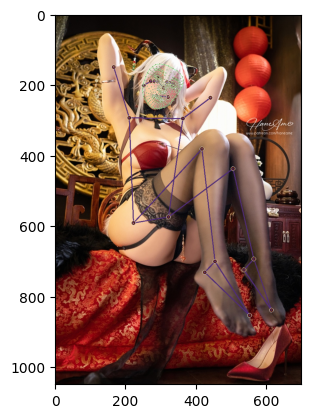

In [10]:
# test mediapipe

import cv2
import matplotlib.pyplot as plt
img = cv2.imread("test_image2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

with mp_holistic.Holistic() as holistic:
    results = holistic.process(img)
    mp_drawing.draw_landmarks(img, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                                mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                ) 

    mp_drawing.draw_landmarks(img, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                                mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                ) 

    mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                                mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                ) 
    mp_drawing.draw_landmarks(img, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, # FACEMESH_TESSELATION for full face
                                mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                                mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                ) 
    print(results.left_hand_landmarks)
    print(results.right_hand_landmarks)
    # print(results.pose_landmarks.landmark[0:23])
    # print(results.face_landmarks)
    plt.imshow(img)


In [11]:
import mediapipe as mp
import cv2
import numpy as np

recognizer = mp.solutions.holistic.Holistic() # this takes both face and hands landmarks

def get_bound_landmark(landmarks):
    min_x = min(landmark.x for landmark in landmarks if landmark.x<=1 and landmark.x>=0)
    min_y = min(landmark.y for landmark in landmarks if landmark.y<=1 and landmark.y>=0)
    max_x = max(landmark.x for landmark in landmarks if landmark.x<=1 and landmark.x>=0)
    max_y = max(landmark.y for landmark in landmarks if landmark.y<=1 and landmark.y>=0)
    return min_x, min_y, max_x, max_y

def make_landmark_timestep(landmarks):
  c_lm = []
  for landmark in landmarks:
    c_lm.append(landmark.x)
    c_lm.append(landmark.y)
    c_lm.append(landmark.z)
  return c_lm

def make_zeros():
  return np.zeros((63)).tolist()

def normalize(landmarks, frame_width, frame_height): 

    opsize = 0
    min_x, min_y, max_x, max_y = get_bound_landmark(landmarks)
    center_x, center_y = (max_x+min_x)/2, (max_y+min_y)/2

    for mark in landmarks:
        x,y = (mark.x*frame_width,mark.y*frame_height)
        opsize = max([abs(x-center_x),opsize,abs(y-center_y)])
    opsize = opsize*2
    
    for i,mark in enumerate(landmarks):
        x,y = (mark.x*frame_width,mark.y*frame_height)
        x = x-center_x+opsize/2
        y = y-center_y+opsize/2
        x = x/opsize
        y = y/opsize
        landmarks[i].x = x
        landmarks[i].y = y
    return landmarks

def load_video(video_path, size=(256,256)): # mỗi video trả về một list result_landmarks cho mỗi video
  cap = cv2.VideoCapture(video_path)
  result_landmarks = []
  result_frames = []
  while cap.isOpened():
      # Đọc frame
      ret, frame = cap.read()
      if not ret:
        break
      # Chuyển đổi frame sang RGB
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      # Xác định pose
      height, width = frame_rgb.shape[:2]
      center_y = height//2
      center_x = width//2
      max_size = min(height,width)
      centered =frame_rgb[center_y-max_size//2:center_y+max_size//2,center_x-max_size//2:center_x+max_size//2]
      results = recognizer.process(centered)

      landmarks = []
      count_zeros = 0

      if results.pose_landmarks:
         landmarks.extend(make_landmark_timestep(results.pose_landmarks.landmark[0:23]))

      if results.left_hand_landmarks:
         landmarks.extend(make_landmark_timestep(results.left_hand_landmarks.landmark))
      else:
         landmarks.extend(make_zeros())
         count_zeros+=1

      if results.right_hand_landmarks:
         landmarks.extend(make_landmark_timestep(results.right_hand_landmarks.landmark))
      else:
         landmarks.extend(make_zeros())
         count_zeros+=1

      # print(landmarks)
      if count_zeros<2:
        # print(len(landmarks))
        result_landmarks.append(landmarks)
        centered = cv2.resize(centered,size,interpolation=cv2.INTER_AREA)
        result_frames.append(cv2.cvtColor(centered,cv2.COLOR_RGB2BGR))
  return result_landmarks, result_frames

In [ ]:
# import numpy as np
# landmarks, frames = load_video("test_video1.mp4")
# print(len(landmarks))
# l = np.array(landmarks)
# f = np.array(frames)
# print(l.shape)
# print(f.shape)

In [17]:
import pandas as pd
import os
def load_all(directory,save_directory, size=(256,256)):
    folder_list = os.listdir(directory)[3:29]
    # folder_list = ['barbell biceps curl','bench press']
    for folder in folder_list:
        count = 0
        subfolder = os.path.join(directory,folder)
        save_subpath = os.path.join(save_directory,folder)
        
        if not os.path.exists(save_subpath):
            os.makedirs(save_subpath)

        print(folder)

        list_video = os.listdir(subfolder)
        for video in list_video:
            count+=1
            path_in = os.path.join(subfolder,video) 
            name = video.split("_")[0] + "_" + str(count)
            path_out = os.path.join(save_subpath,name)
            landmarks, frames = load_video(path_in, size)
            outwrite = cv2.VideoWriter(path_out+".mp4", cv2.VideoWriter_fourcc(*'mp4v'),30.0,size)
            for frame in frames:
                outwrite.write(frame)
            outwrite.release()
            landmarks = pd.DataFrame(landmarks)
            landmarks.to_csv(path_out+".txt")

In [19]:
directory = "Data"
save_directory = "Data_processed/"
load_all(directory,save_directory, (128,128))

3
4
5
6
7
8
9
A
Anh hai
B
Ban ngày
Ban đêm
Buổi chiều
Buổi sáng
Buổi trưa
Buổi tối
Bố
C
Chơi
Chị
cách-
Cô giáo
Cơm
Cười
Cảm ơn
D
